# Mask R-CNN - Train on Shapes Dataset


This notebook shows how to train Mask R-CNN on your own dataset. To keep things simple we use a synthetic dataset of shapes (squares, triangles, and circles) which enables fast training. You'd still need a GPU, though, because the network backbone is a Resnet101, which would be too slow to train on a CPU. On a GPU, you can start to get okay-ish results in a few minutes, and good results in less than an hour.

The code of the *Shapes* dataset is included below. It generates images on the fly, so it doesn't require downloading any data. And it can generate images of any size, so we pick a small image size to train faster. 

In [1]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt

# Root directory of the project
ROOT_DIR = os.path.abspath("../../")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/

## Configurations

In [2]:
class ShapesConfig(Config):
    """Configuration for training on the toy shapes dataset.
    Derives from the base Config class and overrides values specific
    to the toy shapes dataset.
    """
    # Give the configuration a recognizable name
    NAME = "shapes"

    # Train on 1 GPU and 8 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 8 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 8

    # Number of classes (including background)
    NUM_CLASSES = 1 + 3  # background + 3 shapes

    # Use small images for faster training. Set the limits of the small side
    # the large side, and that determines the image shape.
    IMAGE_MIN_DIM = 128
    IMAGE_MAX_DIM = 128

    # Use smaller anchors because our image and objects are small
    RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128)  # anchor side in pixels

    # Reduce training ROIs per image because the images are small and have
    # few objects. Aim to allow ROI sampling to pick 33% positive ROIs.
    TRAIN_ROIS_PER_IMAGE = 32

    # Use a small epoch since the data is simple
    STEPS_PER_EPOCH = 100

    # use small validation steps since the epoch is small
    VALIDATION_STEPS = 5
    
config = ShapesConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     8
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 8
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  128
IMAGE_META_SIZE                16
IMAGE_MIN_DIM                  128
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [128 128   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE             

## Notebook Preferences

In [3]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

## Dataset

Create a synthetic dataset

Extend the Dataset class and add a method to load the shapes dataset, `load_shapes()`, and override the following methods:

* load_image()
* load_mask()
* image_reference()

In [4]:
class ShapesDataset(utils.Dataset):
    """Generates the shapes synthetic dataset. The dataset consists of simple
    shapes (triangles, squares, circles) placed randomly on a blank surface.
    The images are generated on the fly. No file access required.
    """

    def load_shapes(self, count, height, width):
        """Generate the requested number of synthetic images.
        count: number of images to generate.
        height, width: the size of the generated images.
        """
        # Add classes
        self.add_class("shapes", 1, "square")
        self.add_class("shapes", 2, "circle")
        self.add_class("shapes", 3, "triangle")

        # Add images
        # Generate random specifications of images (i.e. color and
        # list of shapes sizes and locations). This is more compact than
        # actual images. Images are generated on the fly in load_image().
        for i in range(count):
            bg_color, shapes = self.random_image(height, width)
            self.add_image("shapes", image_id=i, path=None,
                           width=width, height=height,
                           bg_color=bg_color, shapes=shapes)

    def load_image(self, image_id):
        """Generate an image from the specs of the given image ID.
        Typically this function loads the image from a file, but
        in this case it generates the image on the fly from the
        specs in image_info.
        """
        info = self.image_info[image_id]
        bg_color = np.array(info['bg_color']).reshape([1, 1, 3])
        image = np.ones([info['height'], info['width'], 3], dtype=np.uint8)
        image = image * bg_color.astype(np.uint8)
        for shape, color, dims in info['shapes']:
            image = self.draw_shape(image, shape, dims, color)
        return image

    def image_reference(self, image_id):
        """Return the shapes data of the image."""
        info = self.image_info[image_id]
        if info["source"] == "shapes":
            return info["shapes"]
        else:
            super(self.__class__).image_reference(self, image_id)

    def load_mask(self, image_id):
        """Generate instance masks for shapes of the given image ID.
        """
        info = self.image_info[image_id]
        shapes = info['shapes']
        count = len(shapes)
        mask = np.zeros([info['height'], info['width'], count], dtype=np.uint8)
        for i, (shape, _, dims) in enumerate(info['shapes']):
            mask[:, :, i:i+1] = self.draw_shape(mask[:, :, i:i+1].copy(),
                                                shape, dims, 1)
        # Handle occlusions
        occlusion = np.logical_not(mask[:, :, -1]).astype(np.uint8)
        for i in range(count-2, -1, -1):
            mask[:, :, i] = mask[:, :, i] * occlusion
            occlusion = np.logical_and(occlusion, np.logical_not(mask[:, :, i]))
        # Map class names to class IDs.
        class_ids = np.array([self.class_names.index(s[0]) for s in shapes])
        return mask.astype(np.bool), class_ids.astype(np.int32)

    def draw_shape(self, image, shape, dims, color):
        """Draws a shape from the given specs."""
        # Get the center x, y and the size s
        x, y, s = dims
        if shape == 'square':
            cv2.rectangle(image, (x-s, y-s), (x+s, y+s), color, -1)
        elif shape == "circle":
            cv2.circle(image, (x, y), s, color, -1)
        elif shape == "triangle":
            points = np.array([[(x, y-s),
                                (x-s/math.sin(math.radians(60)), y+s),
                                (x+s/math.sin(math.radians(60)), y+s),
                                ]], dtype=np.int32)
            cv2.fillPoly(image, points, color)
        return image

    def random_shape(self, height, width):
        """Generates specifications of a random shape that lies within
        the given height and width boundaries.
        Returns a tuple of three valus:
        * The shape name (square, circle, ...)
        * Shape color: a tuple of 3 values, RGB.
        * Shape dimensions: A tuple of values that define the shape size
                            and location. Differs per shape type.
        """
        # Shape
        shape = random.choice(["square", "circle", "triangle"])
        # Color
        color = tuple([random.randint(0, 255) for _ in range(3)])
        # Center x, y
        buffer = 20
        y = random.randint(buffer, height - buffer - 1)
        x = random.randint(buffer, width - buffer - 1)
        # Size
        s = random.randint(buffer, height//4)
        return shape, color, (x, y, s)

    def random_image(self, height, width):
        """Creates random specifications of an image with multiple shapes.
        Returns the background color of the image and a list of shape
        specifications that can be used to draw the image.
        """
        # Pick random background color
        bg_color = np.array([random.randint(0, 255) for _ in range(3)])
        # Generate a few random shapes and record their
        # bounding boxes
        shapes = []
        boxes = []
        N = random.randint(1, 4)
        for _ in range(N):
            shape, color, dims = self.random_shape(height, width)
            shapes.append((shape, color, dims))
            x, y, s = dims
            boxes.append([y-s, x-s, y+s, x+s])
        # Apply non-max suppression wit 0.3 threshold to avoid
        # shapes covering each other
        keep_ixs = utils.non_max_suppression(np.array(boxes), np.arange(N), 0.3)
        shapes = [s for i, s in enumerate(shapes) if i in keep_ixs]
        return bg_color, shapes

In [5]:
# Training dataset
dataset_train = ShapesDataset()
dataset_train.load_shapes(500, config.IMAGE_SHAPE[0], config.IMAGE_SHAPE[1])
dataset_train.prepare()

# Validation dataset
dataset_val = ShapesDataset()
dataset_val.load_shapes(50, config.IMAGE_SHAPE[0], config.IMAGE_SHAPE[1])
dataset_val.prepare()

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


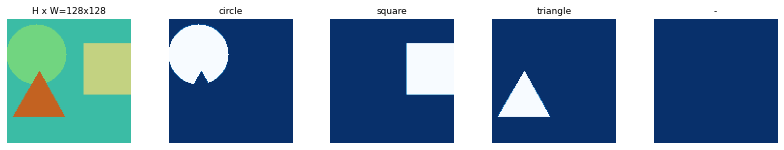

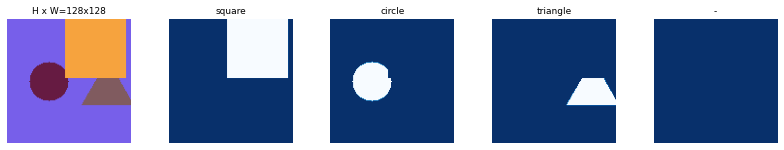

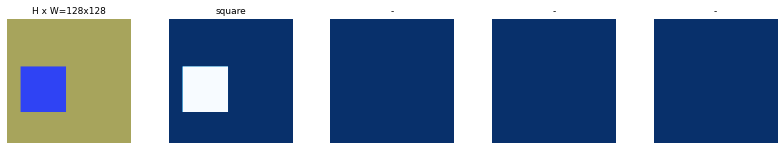

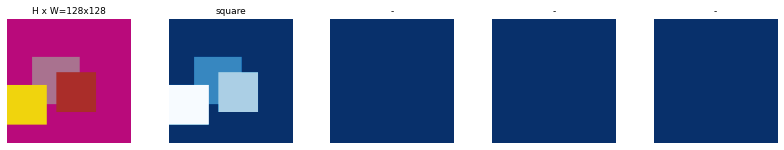

In [6]:
# Load and display random samples
image_ids = np.random.choice(dataset_train.image_ids, 4)
for image_id in image_ids:
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)

## Create Model

In [7]:
# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [11]:
# Which weights to start with?
init_with = "imagenet"  # imagenet, coco, or last

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last(), by_name=True)

Import error! Running from keras.engine import topology as saving instead


2022-08-26 15:57:35.882095: I tensorflow/core/platform/cpu_feature_guard.cc:141] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA


## Training

Train in two stages:
1. Only the heads. Here we're freezing all the backbone layers and training only the randomly initialized layers (i.e. the ones that we didn't use pre-trained weights from MS COCO). To train only the head layers, pass `layers='heads'` to the `train()` function.

2. Fine-tune all layers. For this simple example it's not necessary, but we're including it to show the process. Simply pass `layers="all` to train all layers.

In [12]:
# Train the head branches
# Passing layers="heads" freezes all layers except the head
# layers. You can also pass a regular expression to select
# which layers to train by name pattern.
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE, 
            epochs=1, 
            layers='heads')


Starting at epoch 0. LR=0.001

Checkpoint Path: /Users/melvingelbard/Documents/repos/Mask_RCNN/logs/shapes20220826T1557/mask_rcnn_shapes_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (Ti

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/tensorflow/python/ops/gradients_impl.py:110: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/keras/engine/training.py:1987: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

Epoch 1/1


/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

  1/100 [..............................] - ETA: 1747s - loss: 7.2599 - rpn_class_loss: 1.2994 - rpn_bbox_loss: 1.6526 - mrcnn_class_loss: 1.0079 - mrcnn_bbox_loss: 2.5683 - mrcnn_mask_loss: 0.7318

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

  2/100 [..............................] - ETA: 1430s - loss: 7.0455 - rpn_class_loss: 1.2598 - rpn_bbox_loss: 1.6437 - mrcnn_class_loss: 1.0839 - mrcnn_bbox_loss: 2.3535 - mrcnn_mask_loss: 0.7046

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

  3/100 [..............................] - ETA: 1316s - loss: 6.8065 - rpn_class_loss: 1.0932 - rpn_bbox_loss: 1.5775 - mrcnn_class_loss: 1.1549 - mrcnn_bbox_loss: 2.2738 - mrcnn_mask_loss: 0.7071

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

  4/100 [>.............................] - ETA: 1253s - loss: 6.5382 - rpn_class_loss: 0.9272 - rpn_bbox_loss: 1.6512 - mrcnn_class_loss: 1.1794 - mrcnn_bbox_loss: 2.0742 - mrcnn_mask_loss: 0.7062

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

  5/100 [>.............................] - ETA: 1210s - loss: 6.1516 - rpn_class_loss: 0.7960 - rpn_bbox_loss: 1.6016 - mrcnn_class_loss: 1.0705 - mrcnn_bbox_loss: 1.9763 - mrcnn_mask_loss: 0.7073

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

  6/100 [>.............................] - ETA: 1178s - loss: 5.8187 - rpn_class_loss: 0.6914 - rpn_bbox_loss: 1.5896 - mrcnn_class_loss: 0.9949 - mrcnn_bbox_loss: 1.8383 - mrcnn_mask_loss: 0.7045

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

  7/100 [=>............................] - ETA: 1164s - loss: 5.6172 - rpn_class_loss: 0.6124 - rpn_bbox_loss: 1.5569 - mrcnn_class_loss: 1.0222 - mrcnn_bbox_loss: 1.7266 - mrcnn_mask_loss: 0.6991

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

  8/100 [=>............................] - ETA: 1142s - loss: 5.4699 - rpn_class_loss: 0.5528 - rpn_bbox_loss: 1.5723 - mrcnn_class_loss: 0.9867 - mrcnn_bbox_loss: 1.6596 - mrcnn_mask_loss: 0.6984

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

  9/100 [=>............................] - ETA: 1141s - loss: 5.3629 - rpn_class_loss: 0.5026 - rpn_bbox_loss: 1.5731 - mrcnn_class_loss: 0.9734 - mrcnn_bbox_loss: 1.6144 - mrcnn_mask_loss: 0.6994

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

 10/100 [==>...........................] - ETA: 1122s - loss: 5.1953 - rpn_class_loss: 0.4616 - rpn_bbox_loss: 1.5224 - mrcnn_class_loss: 0.9457 - mrcnn_bbox_loss: 1.5689 - mrcnn_mask_loss: 0.6967

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

 11/100 [==>...........................] - ETA: 1101s - loss: 5.0983 - rpn_class_loss: 0.4288 - rpn_bbox_loss: 1.5371 - mrcnn_class_loss: 0.9263 - mrcnn_bbox_loss: 1.5135 - mrcnn_mask_loss: 0.6926

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

 12/100 [==>...........................] - ETA: 1084s - loss: 5.0399 - rpn_class_loss: 0.4004 - rpn_bbox_loss: 1.5357 - mrcnn_class_loss: 0.9216 - mrcnn_bbox_loss: 1.4903 - mrcnn_mask_loss: 0.6919

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

 13/100 [==>...........................] - ETA: 1064s - loss: 4.9564 - rpn_class_loss: 0.3758 - rpn_bbox_loss: 1.5106 - mrcnn_class_loss: 0.9164 - mrcnn_bbox_loss: 1.4625 - mrcnn_mask_loss: 0.6910

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

 14/100 [===>..........................] - ETA: 1048s - loss: 4.8794 - rpn_class_loss: 0.3539 - rpn_bbox_loss: 1.5018 - mrcnn_class_loss: 0.8965 - mrcnn_bbox_loss: 1.4343 - mrcnn_mask_loss: 0.6928

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

 15/100 [===>..........................] - ETA: 1031s - loss: 4.8169 - rpn_class_loss: 0.3344 - rpn_bbox_loss: 1.4952 - mrcnn_class_loss: 0.8823 - mrcnn_bbox_loss: 1.4136 - mrcnn_mask_loss: 0.6914

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

 16/100 [===>..........................] - ETA: 1013s - loss: 4.7523 - rpn_class_loss: 0.3177 - rpn_bbox_loss: 1.4807 - mrcnn_class_loss: 0.8692 - mrcnn_bbox_loss: 1.3950 - mrcnn_mask_loss: 0.6897

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

 17/100 [====>.........................] - ETA: 997s - loss: 4.6838 - rpn_class_loss: 0.3031 - rpn_bbox_loss: 1.4645 - mrcnn_class_loss: 0.8458 - mrcnn_bbox_loss: 1.3797 - mrcnn_mask_loss: 0.6906 

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

 18/100 [====>.........................] - ETA: 981s - loss: 4.6190 - rpn_class_loss: 0.2899 - rpn_bbox_loss: 1.4532 - mrcnn_class_loss: 0.8322 - mrcnn_bbox_loss: 1.3536 - mrcnn_mask_loss: 0.6901

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

 19/100 [====>.........................] - ETA: 966s - loss: 4.5446 - rpn_class_loss: 0.2781 - rpn_bbox_loss: 1.4347 - mrcnn_class_loss: 0.8116 - mrcnn_bbox_loss: 1.3285 - mrcnn_mask_loss: 0.6916

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

 20/100 [=====>........................] - ETA: 953s - loss: 4.4633 - rpn_class_loss: 0.2669 - rpn_bbox_loss: 1.4112 - mrcnn_class_loss: 0.7850 - mrcnn_bbox_loss: 1.3084 - mrcnn_mask_loss: 0.6918

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

 21/100 [=====>........................] - ETA: 940s - loss: 4.4064 - rpn_class_loss: 0.2570 - rpn_bbox_loss: 1.4021 - mrcnn_class_loss: 0.7672 - mrcnn_bbox_loss: 1.2879 - mrcnn_mask_loss: 0.6923

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

 22/100 [=====>........................] - ETA: 927s - loss: 4.3413 - rpn_class_loss: 0.2478 - rpn_bbox_loss: 1.3798 - mrcnn_class_loss: 0.7559 - mrcnn_bbox_loss: 1.2660 - mrcnn_mask_loss: 0.6918

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

 23/100 [=====>........................] - ETA: 914s - loss: 4.2866 - rpn_class_loss: 0.2392 - rpn_bbox_loss: 1.3644 - mrcnn_class_loss: 0.7415 - mrcnn_bbox_loss: 1.2509 - mrcnn_mask_loss: 0.6906

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

 24/100 [======>.......................] - ETA: 901s - loss: 4.2323 - rpn_class_loss: 0.2315 - rpn_bbox_loss: 1.3514 - mrcnn_class_loss: 0.7264 - mrcnn_bbox_loss: 1.2342 - mrcnn_mask_loss: 0.6887

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

 25/100 [======>.......................] - ETA: 888s - loss: 4.1851 - rpn_class_loss: 0.2243 - rpn_bbox_loss: 1.3485 - mrcnn_class_loss: 0.7035 - mrcnn_bbox_loss: 1.2187 - mrcnn_mask_loss: 0.6901

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

 26/100 [======>.......................] - ETA: 875s - loss: 4.1367 - rpn_class_loss: 0.2174 - rpn_bbox_loss: 1.3353 - mrcnn_class_loss: 0.6931 - mrcnn_bbox_loss: 1.2024 - mrcnn_mask_loss: 0.6884

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

 27/100 [=======>......................] - ETA: 862s - loss: 4.0842 - rpn_class_loss: 0.2105 - rpn_bbox_loss: 1.3168 - mrcnn_class_loss: 0.6778 - mrcnn_bbox_loss: 1.1911 - mrcnn_mask_loss: 0.6879

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

 28/100 [=======>......................] - ETA: 849s - loss: 4.0503 - rpn_class_loss: 0.2049 - rpn_bbox_loss: 1.3185 - mrcnn_class_loss: 0.6627 - mrcnn_bbox_loss: 1.1771 - mrcnn_mask_loss: 0.6871

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

 29/100 [=======>......................] - ETA: 837s - loss: 4.0184 - rpn_class_loss: 0.1992 - rpn_bbox_loss: 1.3173 - mrcnn_class_loss: 0.6502 - mrcnn_bbox_loss: 1.1645 - mrcnn_mask_loss: 0.6872

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

 30/100 [========>.....................] - ETA: 824s - loss: 3.9962 - rpn_class_loss: 0.1937 - rpn_bbox_loss: 1.3213 - mrcnn_class_loss: 0.6334 - mrcnn_bbox_loss: 1.1603 - mrcnn_mask_loss: 0.6875

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

 31/100 [========>.....................] - ETA: 811s - loss: 3.9709 - rpn_class_loss: 0.1885 - rpn_bbox_loss: 1.3194 - mrcnn_class_loss: 0.6236 - mrcnn_bbox_loss: 1.1527 - mrcnn_mask_loss: 0.6868

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

 32/100 [========>.....................] - ETA: 799s - loss: 3.9348 - rpn_class_loss: 0.1840 - rpn_bbox_loss: 1.3069 - mrcnn_class_loss: 0.6174 - mrcnn_bbox_loss: 1.1401 - mrcnn_mask_loss: 0.6863

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

 33/100 [========>.....................] - ETA: 787s - loss: 3.9025 - rpn_class_loss: 0.1795 - rpn_bbox_loss: 1.3023 - mrcnn_class_loss: 0.6083 - mrcnn_bbox_loss: 1.1271 - mrcnn_mask_loss: 0.6853

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

 34/100 [=========>....................] - ETA: 775s - loss: 3.8656 - rpn_class_loss: 0.1752 - rpn_bbox_loss: 1.2895 - mrcnn_class_loss: 0.5971 - mrcnn_bbox_loss: 1.1192 - mrcnn_mask_loss: 0.6846

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

 35/100 [=========>....................] - ETA: 762s - loss: 3.8370 - rpn_class_loss: 0.1713 - rpn_bbox_loss: 1.2848 - mrcnn_class_loss: 0.5901 - mrcnn_bbox_loss: 1.1071 - mrcnn_mask_loss: 0.6836

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

 36/100 [=========>....................] - ETA: 750s - loss: 3.8095 - rpn_class_loss: 0.1676 - rpn_bbox_loss: 1.2739 - mrcnn_class_loss: 0.5842 - mrcnn_bbox_loss: 1.1007 - mrcnn_mask_loss: 0.6831

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

 37/100 [==========>...................] - ETA: 738s - loss: 3.7869 - rpn_class_loss: 0.1644 - rpn_bbox_loss: 1.2701 - mrcnn_class_loss: 0.5771 - mrcnn_bbox_loss: 1.0927 - mrcnn_mask_loss: 0.6825

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

 38/100 [==========>...................] - ETA: 726s - loss: 3.7641 - rpn_class_loss: 0.1612 - rpn_bbox_loss: 1.2704 - mrcnn_class_loss: 0.5672 - mrcnn_bbox_loss: 1.0831 - mrcnn_mask_loss: 0.6822

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

 39/100 [==========>...................] - ETA: 713s - loss: 3.7381 - rpn_class_loss: 0.1582 - rpn_bbox_loss: 1.2640 - mrcnn_class_loss: 0.5610 - mrcnn_bbox_loss: 1.0735 - mrcnn_mask_loss: 0.6815

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

 40/100 [===========>..................] - ETA: 701s - loss: 3.7069 - rpn_class_loss: 0.1553 - rpn_bbox_loss: 1.2540 - mrcnn_class_loss: 0.5522 - mrcnn_bbox_loss: 1.0649 - mrcnn_mask_loss: 0.6805

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

 41/100 [===========>..................] - ETA: 689s - loss: 3.6872 - rpn_class_loss: 0.1526 - rpn_bbox_loss: 1.2559 - mrcnn_class_loss: 0.5440 - mrcnn_bbox_loss: 1.0547 - mrcnn_mask_loss: 0.6801

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

 42/100 [===========>..................] - ETA: 676s - loss: 3.6624 - rpn_class_loss: 0.1502 - rpn_bbox_loss: 1.2500 - mrcnn_class_loss: 0.5362 - mrcnn_bbox_loss: 1.0462 - mrcnn_mask_loss: 0.6798

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

 43/100 [===========>..................] - ETA: 664s - loss: 3.6364 - rpn_class_loss: 0.1475 - rpn_bbox_loss: 1.2411 - mrcnn_class_loss: 0.5308 - mrcnn_bbox_loss: 1.0376 - mrcnn_mask_loss: 0.6794

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

 44/100 [============>.................] - ETA: 652s - loss: 3.6210 - rpn_class_loss: 0.1452 - rpn_bbox_loss: 1.2432 - mrcnn_class_loss: 0.5246 - mrcnn_bbox_loss: 1.0293 - mrcnn_mask_loss: 0.6787

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

 45/100 [============>.................] - ETA: 640s - loss: 3.5937 - rpn_class_loss: 0.1427 - rpn_bbox_loss: 1.2343 - mrcnn_class_loss: 0.5179 - mrcnn_bbox_loss: 1.0214 - mrcnn_mask_loss: 0.6773

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

 46/100 [============>.................] - ETA: 628s - loss: 3.5714 - rpn_class_loss: 0.1403 - rpn_bbox_loss: 1.2272 - mrcnn_class_loss: 0.5130 - mrcnn_bbox_loss: 1.0145 - mrcnn_mask_loss: 0.6764

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

 47/100 [=============>................] - ETA: 615s - loss: 3.5500 - rpn_class_loss: 0.1382 - rpn_bbox_loss: 1.2247 - mrcnn_class_loss: 0.5058 - mrcnn_bbox_loss: 1.0056 - mrcnn_mask_loss: 0.6757

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

 48/100 [=============>................] - ETA: 603s - loss: 3.5224 - rpn_class_loss: 0.1362 - rpn_bbox_loss: 1.2159 - mrcnn_class_loss: 0.4995 - mrcnn_bbox_loss: 0.9955 - mrcnn_mask_loss: 0.6754

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

 49/100 [=============>................] - ETA: 591s - loss: 3.5028 - rpn_class_loss: 0.1342 - rpn_bbox_loss: 1.2083 - mrcnn_class_loss: 0.4973 - mrcnn_bbox_loss: 0.9879 - mrcnn_mask_loss: 0.6750

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

 50/100 [==============>...............] - ETA: 579s - loss: 3.4811 - rpn_class_loss: 0.1321 - rpn_bbox_loss: 1.2024 - mrcnn_class_loss: 0.4915 - mrcnn_bbox_loss: 0.9806 - mrcnn_mask_loss: 0.6746

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

 51/100 [==============>...............] - ETA: 567s - loss: 3.4642 - rpn_class_loss: 0.1304 - rpn_bbox_loss: 1.1996 - mrcnn_class_loss: 0.4856 - mrcnn_bbox_loss: 0.9746 - mrcnn_mask_loss: 0.6740

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

 52/100 [==============>...............] - ETA: 555s - loss: 3.4474 - rpn_class_loss: 0.1286 - rpn_bbox_loss: 1.1954 - mrcnn_class_loss: 0.4807 - mrcnn_bbox_loss: 0.9689 - mrcnn_mask_loss: 0.6738

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

 53/100 [==============>...............] - ETA: 543s - loss: 3.4272 - rpn_class_loss: 0.1267 - rpn_bbox_loss: 1.1873 - mrcnn_class_loss: 0.4773 - mrcnn_bbox_loss: 0.9624 - mrcnn_mask_loss: 0.6736

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

 54/100 [===============>..............] - ETA: 532s - loss: 3.4086 - rpn_class_loss: 0.1252 - rpn_bbox_loss: 1.1795 - mrcnn_class_loss: 0.4733 - mrcnn_bbox_loss: 0.9573 - mrcnn_mask_loss: 0.6732

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

 55/100 [===============>..............] - ETA: 520s - loss: 3.3852 - rpn_class_loss: 0.1234 - rpn_bbox_loss: 1.1720 - mrcnn_class_loss: 0.4681 - mrcnn_bbox_loss: 0.9491 - mrcnn_mask_loss: 0.6726

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

 56/100 [===============>..............] - ETA: 508s - loss: 3.3669 - rpn_class_loss: 0.1216 - rpn_bbox_loss: 1.1670 - mrcnn_class_loss: 0.4633 - mrcnn_bbox_loss: 0.9430 - mrcnn_mask_loss: 0.6719

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

 57/100 [================>.............] - ETA: 496s - loss: 3.3452 - rpn_class_loss: 0.1200 - rpn_bbox_loss: 1.1581 - mrcnn_class_loss: 0.4585 - mrcnn_bbox_loss: 0.9369 - mrcnn_mask_loss: 0.6716

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

 58/100 [================>.............] - ETA: 485s - loss: 3.3285 - rpn_class_loss: 0.1185 - rpn_bbox_loss: 1.1532 - mrcnn_class_loss: 0.4532 - mrcnn_bbox_loss: 0.9326 - mrcnn_mask_loss: 0.6709

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

 59/100 [================>.............] - ETA: 473s - loss: 3.3091 - rpn_class_loss: 0.1169 - rpn_bbox_loss: 1.1464 - mrcnn_class_loss: 0.4480 - mrcnn_bbox_loss: 0.9275 - mrcnn_mask_loss: 0.6704

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

 60/100 [=================>............] - ETA: 461s - loss: 3.2938 - rpn_class_loss: 0.1154 - rpn_bbox_loss: 1.1437 - mrcnn_class_loss: 0.4429 - mrcnn_bbox_loss: 0.9217 - mrcnn_mask_loss: 0.6702

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

 61/100 [=================>............] - ETA: 449s - loss: 3.2814 - rpn_class_loss: 0.1143 - rpn_bbox_loss: 1.1401 - mrcnn_class_loss: 0.4397 - mrcnn_bbox_loss: 0.9174 - mrcnn_mask_loss: 0.6698

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

 62/100 [=================>............] - ETA: 438s - loss: 3.2605 - rpn_class_loss: 0.1129 - rpn_bbox_loss: 1.1311 - mrcnn_class_loss: 0.4351 - mrcnn_bbox_loss: 0.9119 - mrcnn_mask_loss: 0.6695

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

 63/100 [=================>............] - ETA: 426s - loss: 3.2474 - rpn_class_loss: 0.1117 - rpn_bbox_loss: 1.1289 - mrcnn_class_loss: 0.4315 - mrcnn_bbox_loss: 0.9062 - mrcnn_mask_loss: 0.6691

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

 64/100 [==================>...........] - ETA: 414s - loss: 3.2308 - rpn_class_loss: 0.1104 - rpn_bbox_loss: 1.1217 - mrcnn_class_loss: 0.4282 - mrcnn_bbox_loss: 0.9014 - mrcnn_mask_loss: 0.6692

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

 65/100 [==================>...........] - ETA: 403s - loss: 3.2177 - rpn_class_loss: 0.1092 - rpn_bbox_loss: 1.1198 - mrcnn_class_loss: 0.4245 - mrcnn_bbox_loss: 0.8955 - mrcnn_mask_loss: 0.6687

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

 66/100 [==================>...........] - ETA: 391s - loss: 3.1978 - rpn_class_loss: 0.1078 - rpn_bbox_loss: 1.1121 - mrcnn_class_loss: 0.4201 - mrcnn_bbox_loss: 0.8899 - mrcnn_mask_loss: 0.6679

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

 67/100 [===================>..........] - ETA: 379s - loss: 3.1792 - rpn_class_loss: 0.1066 - rpn_bbox_loss: 1.1066 - mrcnn_class_loss: 0.4147 - mrcnn_bbox_loss: 0.8838 - mrcnn_mask_loss: 0.6675

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

 68/100 [===================>..........] - ETA: 367s - loss: 3.1637 - rpn_class_loss: 0.1055 - rpn_bbox_loss: 1.1001 - mrcnn_class_loss: 0.4117 - mrcnn_bbox_loss: 0.8794 - mrcnn_mask_loss: 0.6671

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

 69/100 [===================>..........] - ETA: 356s - loss: 3.1482 - rpn_class_loss: 0.1045 - rpn_bbox_loss: 1.0950 - mrcnn_class_loss: 0.4085 - mrcnn_bbox_loss: 0.8733 - mrcnn_mask_loss: 0.6669

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

 70/100 [====================>.........] - ETA: 344s - loss: 3.1343 - rpn_class_loss: 0.1034 - rpn_bbox_loss: 1.0904 - mrcnn_class_loss: 0.4047 - mrcnn_bbox_loss: 0.8692 - mrcnn_mask_loss: 0.6665

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

 71/100 [====================>.........] - ETA: 333s - loss: 3.1219 - rpn_class_loss: 0.1024 - rpn_bbox_loss: 1.0859 - mrcnn_class_loss: 0.4015 - mrcnn_bbox_loss: 0.8656 - mrcnn_mask_loss: 0.6665

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

 72/100 [====================>.........] - ETA: 321s - loss: 3.1102 - rpn_class_loss: 0.1015 - rpn_bbox_loss: 1.0830 - mrcnn_class_loss: 0.3983 - mrcnn_bbox_loss: 0.8613 - mrcnn_mask_loss: 0.6661

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

 73/100 [====================>.........] - ETA: 309s - loss: 3.0969 - rpn_class_loss: 0.1005 - rpn_bbox_loss: 1.0785 - mrcnn_class_loss: 0.3950 - mrcnn_bbox_loss: 0.8572 - mrcnn_mask_loss: 0.6657

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

 74/100 [=====================>........] - ETA: 298s - loss: 3.0808 - rpn_class_loss: 0.0995 - rpn_bbox_loss: 1.0720 - mrcnn_class_loss: 0.3918 - mrcnn_bbox_loss: 0.8522 - mrcnn_mask_loss: 0.6653

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

 75/100 [=====================>........] - ETA: 286s - loss: 3.0671 - rpn_class_loss: 0.0985 - rpn_bbox_loss: 1.0673 - mrcnn_class_loss: 0.3885 - mrcnn_bbox_loss: 0.8480 - mrcnn_mask_loss: 0.6647

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

 76/100 [=====================>........] - ETA: 275s - loss: 3.0542 - rpn_class_loss: 0.0977 - rpn_bbox_loss: 1.0624 - mrcnn_class_loss: 0.3855 - mrcnn_bbox_loss: 0.8442 - mrcnn_mask_loss: 0.6643

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

 77/100 [======================>.......] - ETA: 263s - loss: 3.0445 - rpn_class_loss: 0.0971 - rpn_bbox_loss: 1.0608 - mrcnn_class_loss: 0.3826 - mrcnn_bbox_loss: 0.8401 - mrcnn_mask_loss: 0.6639

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

 78/100 [======================>.......] - ETA: 252s - loss: 3.0317 - rpn_class_loss: 0.0963 - rpn_bbox_loss: 1.0574 - mrcnn_class_loss: 0.3788 - mrcnn_bbox_loss: 0.8360 - mrcnn_mask_loss: 0.6633

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

 79/100 [======================>.......] - ETA: 240s - loss: 3.0192 - rpn_class_loss: 0.0956 - rpn_bbox_loss: 1.0531 - mrcnn_class_loss: 0.3763 - mrcnn_bbox_loss: 0.8314 - mrcnn_mask_loss: 0.6627

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

 80/100 [=======================>......] - ETA: 229s - loss: 3.0105 - rpn_class_loss: 0.0949 - rpn_bbox_loss: 1.0520 - mrcnn_class_loss: 0.3739 - mrcnn_bbox_loss: 0.8274 - mrcnn_mask_loss: 0.6623

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

 81/100 [=======================>......] - ETA: 217s - loss: 2.9995 - rpn_class_loss: 0.0942 - rpn_bbox_loss: 1.0479 - mrcnn_class_loss: 0.3707 - mrcnn_bbox_loss: 0.8249 - mrcnn_mask_loss: 0.6617

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

 82/100 [=======================>......] - ETA: 206s - loss: 2.9866 - rpn_class_loss: 0.0933 - rpn_bbox_loss: 1.0430 - mrcnn_class_loss: 0.3673 - mrcnn_bbox_loss: 0.8213 - mrcnn_mask_loss: 0.6617

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

 83/100 [=======================>......] - ETA: 194s - loss: 2.9760 - rpn_class_loss: 0.0925 - rpn_bbox_loss: 1.0396 - mrcnn_class_loss: 0.3642 - mrcnn_bbox_loss: 0.8180 - mrcnn_mask_loss: 0.6617

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

 84/100 [========================>.....] - ETA: 183s - loss: 2.9630 - rpn_class_loss: 0.0917 - rpn_bbox_loss: 1.0350 - mrcnn_class_loss: 0.3616 - mrcnn_bbox_loss: 0.8137 - mrcnn_mask_loss: 0.6611

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

 85/100 [========================>.....] - ETA: 171s - loss: 2.9483 - rpn_class_loss: 0.0909 - rpn_bbox_loss: 1.0284 - mrcnn_class_loss: 0.3587 - mrcnn_bbox_loss: 0.8098 - mrcnn_mask_loss: 0.6606

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

 86/100 [========================>.....] - ETA: 160s - loss: 2.9398 - rpn_class_loss: 0.0903 - rpn_bbox_loss: 1.0247 - mrcnn_class_loss: 0.3575 - mrcnn_bbox_loss: 0.8074 - mrcnn_mask_loss: 0.6599

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

 87/100 [=========================>....] - ETA: 148s - loss: 2.9277 - rpn_class_loss: 0.0895 - rpn_bbox_loss: 1.0195 - mrcnn_class_loss: 0.3549 - mrcnn_bbox_loss: 0.8043 - mrcnn_mask_loss: 0.6595

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

 88/100 [=========================>....] - ETA: 137s - loss: 2.9177 - rpn_class_loss: 0.0888 - rpn_bbox_loss: 1.0157 - mrcnn_class_loss: 0.3530 - mrcnn_bbox_loss: 0.8013 - mrcnn_mask_loss: 0.6588

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

 89/100 [=========================>....] - ETA: 125s - loss: 2.9061 - rpn_class_loss: 0.0882 - rpn_bbox_loss: 1.0117 - mrcnn_class_loss: 0.3501 - mrcnn_bbox_loss: 0.7974 - mrcnn_mask_loss: 0.6587

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

 90/100 [==========================>...] - ETA: 114s - loss: 2.8966 - rpn_class_loss: 0.0874 - rpn_bbox_loss: 1.0084 - mrcnn_class_loss: 0.3482 - mrcnn_bbox_loss: 0.7942 - mrcnn_mask_loss: 0.6583

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

 91/100 [==========================>...] - ETA: 102s - loss: 2.8882 - rpn_class_loss: 0.0869 - rpn_bbox_loss: 1.0058 - mrcnn_class_loss: 0.3457 - mrcnn_bbox_loss: 0.7915 - mrcnn_mask_loss: 0.6583

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

 92/100 [==========================>...] - ETA: 91s - loss: 2.8769 - rpn_class_loss: 0.0862 - rpn_bbox_loss: 1.0020 - mrcnn_class_loss: 0.3436 - mrcnn_bbox_loss: 0.7874 - mrcnn_mask_loss: 0.6577 

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

 93/100 [==========================>...] - ETA: 79s - loss: 2.8677 - rpn_class_loss: 0.0857 - rpn_bbox_loss: 0.9995 - mrcnn_class_loss: 0.3414 - mrcnn_bbox_loss: 0.7841 - mrcnn_mask_loss: 0.6570

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

 94/100 [===========================>..] - ETA: 68s - loss: 2.8594 - rpn_class_loss: 0.0851 - rpn_bbox_loss: 0.9963 - mrcnn_class_loss: 0.3400 - mrcnn_bbox_loss: 0.7812 - mrcnn_mask_loss: 0.6568

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

 95/100 [===========================>..] - ETA: 57s - loss: 2.8484 - rpn_class_loss: 0.0845 - rpn_bbox_loss: 0.9933 - mrcnn_class_loss: 0.3376 - mrcnn_bbox_loss: 0.7769 - mrcnn_mask_loss: 0.6562

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

 96/100 [===========================>..] - ETA: 45s - loss: 2.8374 - rpn_class_loss: 0.0839 - rpn_bbox_loss: 0.9891 - mrcnn_class_loss: 0.3357 - mrcnn_bbox_loss: 0.7732 - mrcnn_mask_loss: 0.6555

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

 97/100 [============================>.] - ETA: 34s - loss: 2.8264 - rpn_class_loss: 0.0832 - rpn_bbox_loss: 0.9849 - mrcnn_class_loss: 0.3338 - mrcnn_bbox_loss: 0.7699 - mrcnn_mask_loss: 0.6546

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

 98/100 [============================>.] - ETA: 22s - loss: 2.8206 - rpn_class_loss: 0.0827 - rpn_bbox_loss: 0.9817 - mrcnn_class_loss: 0.3328 - mrcnn_bbox_loss: 0.7689 - mrcnn_mask_loss: 0.6545

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

 99/100 [============================>.] - ETA: 11s - loss: 2.8121 - rpn_class_loss: 0.0821 - rpn_bbox_loss: 0.9785 - mrcnn_class_loss: 0.3309 - mrcnn_bbox_loss: 0.7662 - mrcnn_mask_loss: 0.6545

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

2022-08-26 16:16:48.909524: W ./tensorflow/core/grappler/optimizers/graph_optimizer_stage.h:241] Failed to run optimizer ArithmeticOptimizer, stage RemoveStackStridedSliceSameAxis node proposal_targets/strided_slice. Error: ValidateStridedSliceOp returned partial shapes [1,?,?] and [?,?]
2022-08-26 16:16:48.909549: W ./tensorflow/core/grappler/optimizers/graph_optimizer_stage.h:241] Failed to run optimizer ArithmeticOptimizer, stage RemoveStackStridedSliceSameAxis node proposal_targets/strided_slice_37. Error: ValidateStridedSliceOp returned partial shapes [1,?,?] and [?,?]
2022-08-26 16:16:48.909562: W ./tensorflow/core/grappler/optimizers/graph_optimizer_stage.h:241] Failed to run optimizer ArithmeticOptimizer, stage RemoveStackStridedSliceSameAxis node proposal_targets/strided_slice_74. Error: ValidateStridedSliceOp returned partial shapes [1,?,?] and [?,?]
2022-08-26 16:16:48.909573: W ./tensorflow/core/grappler/optimizers/graph_optimizer_stage.h:241] Failed to run optimizer Arithm

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


100/100 [==============================] - 1182s - loss: 2.8013 - rpn_class_loss: 0.0815 - rpn_bbox_loss: 0.9750 - mrcnn_class_loss: 0.3286 - mrcnn_bbox_loss: 0.7624 - mrcnn_mask_loss: 0.6538 - val_loss: 2.0376 - val_rpn_class_loss: 0.0236 - val_rpn_bbox_loss: 0.7769 - val_mrcnn_class_loss: 0.1587 - val_mrcnn_bbox_loss: 0.4546 - val_mrcnn_mask_loss: 0.6239


In [13]:
# Fine tune all layers
# Passing layers="all" trains all layers. You can also 
# pass a regular expression to select which layers to
# train by name pattern.
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE / 10,
            epochs=2, 
            layers="all")


Starting at epoch 1. LR=0.0001

Checkpoint Path: /Users/melvingelbard/Documents/repos/Mask_RCNN/logs/shapes20220826T1557/mask_rcnn_shapes_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch2b  

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

Epoch 2/2


/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

  1/100 [..............................] - ETA: 2714s - loss: 1.8716 - rpn_class_loss: 0.0207 - rpn_bbox_loss: 0.7446 - mrcnn_class_loss: 0.1147 - mrcnn_bbox_loss: 0.3695 - mrcnn_mask_loss: 0.6219

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

  2/100 [..............................] - ETA: 1954s - loss: 2.0676 - rpn_class_loss: 0.0248 - rpn_bbox_loss: 0.8070 - mrcnn_class_loss: 0.1623 - mrcnn_bbox_loss: 0.4472 - mrcnn_mask_loss: 0.6263

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

  3/100 [..............................] - ETA: 1668s - loss: 2.1297 - rpn_class_loss: 0.0273 - rpn_bbox_loss: 0.8567 - mrcnn_class_loss: 0.1710 - mrcnn_bbox_loss: 0.4493 - mrcnn_mask_loss: 0.6253

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

  4/100 [>.............................] - ETA: 1517s - loss: 2.1467 - rpn_class_loss: 0.0289 - rpn_bbox_loss: 0.8319 - mrcnn_class_loss: 0.1775 - mrcnn_bbox_loss: 0.4757 - mrcnn_mask_loss: 0.6328

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

  5/100 [>.............................] - ETA: 1426s - loss: 2.1669 - rpn_class_loss: 0.0269 - rpn_bbox_loss: 0.8486 - mrcnn_class_loss: 0.1831 - mrcnn_bbox_loss: 0.4737 - mrcnn_mask_loss: 0.6346

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

  6/100 [>.............................] - ETA: 1360s - loss: 2.0679 - rpn_class_loss: 0.0250 - rpn_bbox_loss: 0.7847 - mrcnn_class_loss: 0.1690 - mrcnn_bbox_loss: 0.4617 - mrcnn_mask_loss: 0.6274

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

  7/100 [=>............................] - ETA: 1309s - loss: 2.0131 - rpn_class_loss: 0.0251 - rpn_bbox_loss: 0.7435 - mrcnn_class_loss: 0.1687 - mrcnn_bbox_loss: 0.4508 - mrcnn_mask_loss: 0.6251

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

  8/100 [=>............................] - ETA: 1267s - loss: 2.0365 - rpn_class_loss: 0.0258 - rpn_bbox_loss: 0.7735 - mrcnn_class_loss: 0.1601 - mrcnn_bbox_loss: 0.4496 - mrcnn_mask_loss: 0.6275

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

  9/100 [=>............................] - ETA: 1233s - loss: 2.0118 - rpn_class_loss: 0.0260 - rpn_bbox_loss: 0.7583 - mrcnn_class_loss: 0.1534 - mrcnn_bbox_loss: 0.4460 - mrcnn_mask_loss: 0.6280

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

 10/100 [==>...........................] - ETA: 1204s - loss: 1.9941 - rpn_class_loss: 0.0265 - rpn_bbox_loss: 0.7504 - mrcnn_class_loss: 0.1503 - mrcnn_bbox_loss: 0.4409 - mrcnn_mask_loss: 0.6261

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

 11/100 [==>...........................] - ETA: 1178s - loss: 1.9888 - rpn_class_loss: 0.0274 - rpn_bbox_loss: 0.7340 - mrcnn_class_loss: 0.1576 - mrcnn_bbox_loss: 0.4412 - mrcnn_mask_loss: 0.6286

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

 12/100 [==>...........................] - ETA: 1153s - loss: 1.9593 - rpn_class_loss: 0.0276 - rpn_bbox_loss: 0.7112 - mrcnn_class_loss: 0.1545 - mrcnn_bbox_loss: 0.4404 - mrcnn_mask_loss: 0.6256

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

 13/100 [==>...........................] - ETA: 1131s - loss: 1.9343 - rpn_class_loss: 0.0270 - rpn_bbox_loss: 0.6910 - mrcnn_class_loss: 0.1542 - mrcnn_bbox_loss: 0.4375 - mrcnn_mask_loss: 0.6245

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

 14/100 [===>..........................] - ETA: 1110s - loss: 1.9252 - rpn_class_loss: 0.0273 - rpn_bbox_loss: 0.6850 - mrcnn_class_loss: 0.1566 - mrcnn_bbox_loss: 0.4330 - mrcnn_mask_loss: 0.6232

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

 15/100 [===>..........................] - ETA: 1091s - loss: 1.9073 - rpn_class_loss: 0.0270 - rpn_bbox_loss: 0.6772 - mrcnn_class_loss: 0.1534 - mrcnn_bbox_loss: 0.4292 - mrcnn_mask_loss: 0.6205

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

 16/100 [===>..........................] - ETA: 1073s - loss: 1.9118 - rpn_class_loss: 0.0271 - rpn_bbox_loss: 0.6865 - mrcnn_class_loss: 0.1557 - mrcnn_bbox_loss: 0.4234 - mrcnn_mask_loss: 0.6191

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

 17/100 [====>.........................] - ETA: 1055s - loss: 1.8948 - rpn_class_loss: 0.0269 - rpn_bbox_loss: 0.6769 - mrcnn_class_loss: 0.1524 - mrcnn_bbox_loss: 0.4217 - mrcnn_mask_loss: 0.6169

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

 18/100 [====>.........................] - ETA: 1038s - loss: 1.8842 - rpn_class_loss: 0.0267 - rpn_bbox_loss: 0.6663 - mrcnn_class_loss: 0.1537 - mrcnn_bbox_loss: 0.4217 - mrcnn_mask_loss: 0.6159

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

 19/100 [====>.........................] - ETA: 1021s - loss: 1.8724 - rpn_class_loss: 0.0267 - rpn_bbox_loss: 0.6601 - mrcnn_class_loss: 0.1523 - mrcnn_bbox_loss: 0.4179 - mrcnn_mask_loss: 0.6154

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

 20/100 [=====>........................] - ETA: 1005s - loss: 1.8790 - rpn_class_loss: 0.0267 - rpn_bbox_loss: 0.6623 - mrcnn_class_loss: 0.1505 - mrcnn_bbox_loss: 0.4222 - mrcnn_mask_loss: 0.6172

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

 21/100 [=====>........................] - ETA: 990s - loss: 1.8803 - rpn_class_loss: 0.0270 - rpn_bbox_loss: 0.6679 - mrcnn_class_loss: 0.1492 - mrcnn_bbox_loss: 0.4204 - mrcnn_mask_loss: 0.6158 

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

 22/100 [=====>........................] - ETA: 974s - loss: 1.8751 - rpn_class_loss: 0.0273 - rpn_bbox_loss: 0.6641 - mrcnn_class_loss: 0.1472 - mrcnn_bbox_loss: 0.4194 - mrcnn_mask_loss: 0.6171

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

 23/100 [=====>........................] - ETA: 960s - loss: 1.8828 - rpn_class_loss: 0.0273 - rpn_bbox_loss: 0.6649 - mrcnn_class_loss: 0.1509 - mrcnn_bbox_loss: 0.4206 - mrcnn_mask_loss: 0.6191

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

 24/100 [======>.......................] - ETA: 945s - loss: 1.8732 - rpn_class_loss: 0.0270 - rpn_bbox_loss: 0.6578 - mrcnn_class_loss: 0.1499 - mrcnn_bbox_loss: 0.4183 - mrcnn_mask_loss: 0.6201

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

 25/100 [======>.......................] - ETA: 930s - loss: 1.8635 - rpn_class_loss: 0.0268 - rpn_bbox_loss: 0.6498 - mrcnn_class_loss: 0.1470 - mrcnn_bbox_loss: 0.4185 - mrcnn_mask_loss: 0.6214

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

 26/100 [======>.......................] - ETA: 916s - loss: 1.8597 - rpn_class_loss: 0.0267 - rpn_bbox_loss: 0.6455 - mrcnn_class_loss: 0.1488 - mrcnn_bbox_loss: 0.4179 - mrcnn_mask_loss: 0.6208

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

 27/100 [=======>......................] - ETA: 902s - loss: 1.8558 - rpn_class_loss: 0.0266 - rpn_bbox_loss: 0.6465 - mrcnn_class_loss: 0.1468 - mrcnn_bbox_loss: 0.4151 - mrcnn_mask_loss: 0.6208

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

 28/100 [=======>......................] - ETA: 888s - loss: 1.8470 - rpn_class_loss: 0.0266 - rpn_bbox_loss: 0.6403 - mrcnn_class_loss: 0.1456 - mrcnn_bbox_loss: 0.4134 - mrcnn_mask_loss: 0.6210

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

 29/100 [=======>......................] - ETA: 874s - loss: 1.8468 - rpn_class_loss: 0.0272 - rpn_bbox_loss: 0.6420 - mrcnn_class_loss: 0.1459 - mrcnn_bbox_loss: 0.4112 - mrcnn_mask_loss: 0.6206

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

 30/100 [========>.....................] - ETA: 861s - loss: 1.8405 - rpn_class_loss: 0.0272 - rpn_bbox_loss: 0.6370 - mrcnn_class_loss: 0.1458 - mrcnn_bbox_loss: 0.4101 - mrcnn_mask_loss: 0.6204

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

 31/100 [========>.....................] - ETA: 847s - loss: 1.8413 - rpn_class_loss: 0.0276 - rpn_bbox_loss: 0.6378 - mrcnn_class_loss: 0.1459 - mrcnn_bbox_loss: 0.4095 - mrcnn_mask_loss: 0.6205

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

 32/100 [========>.....................] - ETA: 834s - loss: 1.8366 - rpn_class_loss: 0.0275 - rpn_bbox_loss: 0.6323 - mrcnn_class_loss: 0.1467 - mrcnn_bbox_loss: 0.4091 - mrcnn_mask_loss: 0.6210

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

 33/100 [========>.....................] - ETA: 820s - loss: 1.8319 - rpn_class_loss: 0.0277 - rpn_bbox_loss: 0.6305 - mrcnn_class_loss: 0.1455 - mrcnn_bbox_loss: 0.4074 - mrcnn_mask_loss: 0.6209

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

 34/100 [=========>....................] - ETA: 807s - loss: 1.8249 - rpn_class_loss: 0.0277 - rpn_bbox_loss: 0.6258 - mrcnn_class_loss: 0.1445 - mrcnn_bbox_loss: 0.4059 - mrcnn_mask_loss: 0.6210

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

 35/100 [=========>....................] - ETA: 794s - loss: 1.8188 - rpn_class_loss: 0.0276 - rpn_bbox_loss: 0.6215 - mrcnn_class_loss: 0.1439 - mrcnn_bbox_loss: 0.4047 - mrcnn_mask_loss: 0.6211

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

 36/100 [=========>....................] - ETA: 781s - loss: 1.8107 - rpn_class_loss: 0.0274 - rpn_bbox_loss: 0.6176 - mrcnn_class_loss: 0.1433 - mrcnn_bbox_loss: 0.4027 - mrcnn_mask_loss: 0.6196

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

 37/100 [==========>...................] - ETA: 768s - loss: 1.8072 - rpn_class_loss: 0.0275 - rpn_bbox_loss: 0.6164 - mrcnn_class_loss: 0.1435 - mrcnn_bbox_loss: 0.4002 - mrcnn_mask_loss: 0.6195

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

 38/100 [==========>...................] - ETA: 755s - loss: 1.8006 - rpn_class_loss: 0.0274 - rpn_bbox_loss: 0.6123 - mrcnn_class_loss: 0.1431 - mrcnn_bbox_loss: 0.3983 - mrcnn_mask_loss: 0.6195

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

 39/100 [==========>...................] - ETA: 742s - loss: 1.8012 - rpn_class_loss: 0.0276 - rpn_bbox_loss: 0.6136 - mrcnn_class_loss: 0.1428 - mrcnn_bbox_loss: 0.3969 - mrcnn_mask_loss: 0.6203

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

 40/100 [===========>..................] - ETA: 730s - loss: 1.8073 - rpn_class_loss: 0.0275 - rpn_bbox_loss: 0.6207 - mrcnn_class_loss: 0.1423 - mrcnn_bbox_loss: 0.3966 - mrcnn_mask_loss: 0.6202

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

 41/100 [===========>..................] - ETA: 717s - loss: 1.8020 - rpn_class_loss: 0.0275 - rpn_bbox_loss: 0.6174 - mrcnn_class_loss: 0.1415 - mrcnn_bbox_loss: 0.3954 - mrcnn_mask_loss: 0.6201

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

 42/100 [===========>..................] - ETA: 705s - loss: 1.7993 - rpn_class_loss: 0.0278 - rpn_bbox_loss: 0.6157 - mrcnn_class_loss: 0.1413 - mrcnn_bbox_loss: 0.3943 - mrcnn_mask_loss: 0.6202

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

 43/100 [===========>..................] - ETA: 692s - loss: 1.7924 - rpn_class_loss: 0.0276 - rpn_bbox_loss: 0.6103 - mrcnn_class_loss: 0.1418 - mrcnn_bbox_loss: 0.3927 - mrcnn_mask_loss: 0.6201

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

 44/100 [============>.................] - ETA: 680s - loss: 1.7859 - rpn_class_loss: 0.0276 - rpn_bbox_loss: 0.6056 - mrcnn_class_loss: 0.1418 - mrcnn_bbox_loss: 0.3912 - mrcnn_mask_loss: 0.6196

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

 45/100 [============>.................] - ETA: 667s - loss: 1.7882 - rpn_class_loss: 0.0279 - rpn_bbox_loss: 0.6066 - mrcnn_class_loss: 0.1420 - mrcnn_bbox_loss: 0.3914 - mrcnn_mask_loss: 0.6203

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

 46/100 [============>.................] - ETA: 654s - loss: 1.7858 - rpn_class_loss: 0.0281 - rpn_bbox_loss: 0.6064 - mrcnn_class_loss: 0.1415 - mrcnn_bbox_loss: 0.3897 - mrcnn_mask_loss: 0.6201

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

 47/100 [=============>................] - ETA: 642s - loss: 1.7826 - rpn_class_loss: 0.0280 - rpn_bbox_loss: 0.6043 - mrcnn_class_loss: 0.1419 - mrcnn_bbox_loss: 0.3888 - mrcnn_mask_loss: 0.6196

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

 48/100 [=============>................] - ETA: 629s - loss: 1.7801 - rpn_class_loss: 0.0278 - rpn_bbox_loss: 0.6028 - mrcnn_class_loss: 0.1423 - mrcnn_bbox_loss: 0.3875 - mrcnn_mask_loss: 0.6197

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

 49/100 [=============>................] - ETA: 617s - loss: 1.7781 - rpn_class_loss: 0.0278 - rpn_bbox_loss: 0.6013 - mrcnn_class_loss: 0.1421 - mrcnn_bbox_loss: 0.3870 - mrcnn_mask_loss: 0.6198

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

 50/100 [==============>...............] - ETA: 605s - loss: 1.7742 - rpn_class_loss: 0.0278 - rpn_bbox_loss: 0.5990 - mrcnn_class_loss: 0.1417 - mrcnn_bbox_loss: 0.3863 - mrcnn_mask_loss: 0.6194

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

 51/100 [==============>...............] - ETA: 592s - loss: 1.7721 - rpn_class_loss: 0.0277 - rpn_bbox_loss: 0.5974 - mrcnn_class_loss: 0.1414 - mrcnn_bbox_loss: 0.3859 - mrcnn_mask_loss: 0.6197

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

 52/100 [==============>...............] - ETA: 580s - loss: 1.7690 - rpn_class_loss: 0.0275 - rpn_bbox_loss: 0.5981 - mrcnn_class_loss: 0.1402 - mrcnn_bbox_loss: 0.3841 - mrcnn_mask_loss: 0.6191

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

 53/100 [==============>...............] - ETA: 568s - loss: 1.7692 - rpn_class_loss: 0.0275 - rpn_bbox_loss: 0.5978 - mrcnn_class_loss: 0.1407 - mrcnn_bbox_loss: 0.3831 - mrcnn_mask_loss: 0.6201

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

 54/100 [===============>..............] - ETA: 555s - loss: 1.7684 - rpn_class_loss: 0.0275 - rpn_bbox_loss: 0.5987 - mrcnn_class_loss: 0.1401 - mrcnn_bbox_loss: 0.3818 - mrcnn_mask_loss: 0.6203

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

 55/100 [===============>..............] - ETA: 543s - loss: 1.7658 - rpn_class_loss: 0.0275 - rpn_bbox_loss: 0.5977 - mrcnn_class_loss: 0.1394 - mrcnn_bbox_loss: 0.3813 - mrcnn_mask_loss: 0.6199

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

 56/100 [===============>..............] - ETA: 531s - loss: 1.7601 - rpn_class_loss: 0.0276 - rpn_bbox_loss: 0.5930 - mrcnn_class_loss: 0.1389 - mrcnn_bbox_loss: 0.3805 - mrcnn_mask_loss: 0.6201

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

 57/100 [================>.............] - ETA: 518s - loss: 1.7587 - rpn_class_loss: 0.0274 - rpn_bbox_loss: 0.5927 - mrcnn_class_loss: 0.1384 - mrcnn_bbox_loss: 0.3797 - mrcnn_mask_loss: 0.6205

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

 58/100 [================>.............] - ETA: 506s - loss: 1.7595 - rpn_class_loss: 0.0275 - rpn_bbox_loss: 0.5915 - mrcnn_class_loss: 0.1397 - mrcnn_bbox_loss: 0.3801 - mrcnn_mask_loss: 0.6206

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

 59/100 [================>.............] - ETA: 494s - loss: 1.7632 - rpn_class_loss: 0.0275 - rpn_bbox_loss: 0.5969 - mrcnn_class_loss: 0.1390 - mrcnn_bbox_loss: 0.3794 - mrcnn_mask_loss: 0.6203

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

 60/100 [=================>............] - ETA: 482s - loss: 1.7601 - rpn_class_loss: 0.0276 - rpn_bbox_loss: 0.5948 - mrcnn_class_loss: 0.1382 - mrcnn_bbox_loss: 0.3792 - mrcnn_mask_loss: 0.6202

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

 61/100 [=================>............] - ETA: 470s - loss: 1.7623 - rpn_class_loss: 0.0278 - rpn_bbox_loss: 0.5957 - mrcnn_class_loss: 0.1393 - mrcnn_bbox_loss: 0.3793 - mrcnn_mask_loss: 0.6201

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

 62/100 [=================>............] - ETA: 457s - loss: 1.7587 - rpn_class_loss: 0.0277 - rpn_bbox_loss: 0.5934 - mrcnn_class_loss: 0.1385 - mrcnn_bbox_loss: 0.3789 - mrcnn_mask_loss: 0.6202

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

 63/100 [=================>............] - ETA: 445s - loss: 1.7569 - rpn_class_loss: 0.0278 - rpn_bbox_loss: 0.5935 - mrcnn_class_loss: 0.1376 - mrcnn_bbox_loss: 0.3779 - mrcnn_mask_loss: 0.6201

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

 64/100 [==================>...........] - ETA: 433s - loss: 1.7524 - rpn_class_loss: 0.0277 - rpn_bbox_loss: 0.5907 - mrcnn_class_loss: 0.1365 - mrcnn_bbox_loss: 0.3775 - mrcnn_mask_loss: 0.6200

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

 65/100 [==================>...........] - ETA: 421s - loss: 1.7519 - rpn_class_loss: 0.0277 - rpn_bbox_loss: 0.5926 - mrcnn_class_loss: 0.1357 - mrcnn_bbox_loss: 0.3761 - mrcnn_mask_loss: 0.6197

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

 66/100 [==================>...........] - ETA: 409s - loss: 1.7476 - rpn_class_loss: 0.0276 - rpn_bbox_loss: 0.5886 - mrcnn_class_loss: 0.1358 - mrcnn_bbox_loss: 0.3761 - mrcnn_mask_loss: 0.6195

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

 67/100 [===================>..........] - ETA: 397s - loss: 1.7413 - rpn_class_loss: 0.0276 - rpn_bbox_loss: 0.5848 - mrcnn_class_loss: 0.1348 - mrcnn_bbox_loss: 0.3747 - mrcnn_mask_loss: 0.6194

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

 68/100 [===================>..........] - ETA: 384s - loss: 1.7359 - rpn_class_loss: 0.0274 - rpn_bbox_loss: 0.5802 - mrcnn_class_loss: 0.1350 - mrcnn_bbox_loss: 0.3737 - mrcnn_mask_loss: 0.6196

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

 69/100 [===================>..........] - ETA: 372s - loss: 1.7385 - rpn_class_loss: 0.0275 - rpn_bbox_loss: 0.5825 - mrcnn_class_loss: 0.1349 - mrcnn_bbox_loss: 0.3733 - mrcnn_mask_loss: 0.6203

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

 70/100 [====================>.........] - ETA: 360s - loss: 1.7360 - rpn_class_loss: 0.0275 - rpn_bbox_loss: 0.5810 - mrcnn_class_loss: 0.1347 - mrcnn_bbox_loss: 0.3724 - mrcnn_mask_loss: 0.6203

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

 71/100 [====================>.........] - ETA: 348s - loss: 1.7354 - rpn_class_loss: 0.0275 - rpn_bbox_loss: 0.5812 - mrcnn_class_loss: 0.1339 - mrcnn_bbox_loss: 0.3724 - mrcnn_mask_loss: 0.6203

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

 72/100 [====================>.........] - ETA: 336s - loss: 1.7343 - rpn_class_loss: 0.0275 - rpn_bbox_loss: 0.5817 - mrcnn_class_loss: 0.1331 - mrcnn_bbox_loss: 0.3714 - mrcnn_mask_loss: 0.6205

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

 73/100 [====================>.........] - ETA: 324s - loss: 1.7298 - rpn_class_loss: 0.0274 - rpn_bbox_loss: 0.5787 - mrcnn_class_loss: 0.1328 - mrcnn_bbox_loss: 0.3707 - mrcnn_mask_loss: 0.6202

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

 74/100 [=====================>........] - ETA: 312s - loss: 1.7272 - rpn_class_loss: 0.0273 - rpn_bbox_loss: 0.5767 - mrcnn_class_loss: 0.1329 - mrcnn_bbox_loss: 0.3702 - mrcnn_mask_loss: 0.6201

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

 75/100 [=====================>........] - ETA: 300s - loss: 1.7280 - rpn_class_loss: 0.0272 - rpn_bbox_loss: 0.5762 - mrcnn_class_loss: 0.1333 - mrcnn_bbox_loss: 0.3708 - mrcnn_mask_loss: 0.6204

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

 76/100 [=====================>........] - ETA: 288s - loss: 1.7263 - rpn_class_loss: 0.0272 - rpn_bbox_loss: 0.5757 - mrcnn_class_loss: 0.1328 - mrcnn_bbox_loss: 0.3707 - mrcnn_mask_loss: 0.6200

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

 77/100 [======================>.......] - ETA: 276s - loss: 1.7236 - rpn_class_loss: 0.0271 - rpn_bbox_loss: 0.5738 - mrcnn_class_loss: 0.1322 - mrcnn_bbox_loss: 0.3708 - mrcnn_mask_loss: 0.6198

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

 78/100 [======================>.......] - ETA: 263s - loss: 1.7222 - rpn_class_loss: 0.0270 - rpn_bbox_loss: 0.5727 - mrcnn_class_loss: 0.1320 - mrcnn_bbox_loss: 0.3703 - mrcnn_mask_loss: 0.6201

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

 79/100 [======================>.......] - ETA: 251s - loss: 1.7189 - rpn_class_loss: 0.0270 - rpn_bbox_loss: 0.5703 - mrcnn_class_loss: 0.1315 - mrcnn_bbox_loss: 0.3699 - mrcnn_mask_loss: 0.6201

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

 80/100 [=======================>......] - ETA: 239s - loss: 1.7145 - rpn_class_loss: 0.0270 - rpn_bbox_loss: 0.5680 - mrcnn_class_loss: 0.1307 - mrcnn_bbox_loss: 0.3687 - mrcnn_mask_loss: 0.6200

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

 81/100 [=======================>......] - ETA: 227s - loss: 1.7128 - rpn_class_loss: 0.0269 - rpn_bbox_loss: 0.5678 - mrcnn_class_loss: 0.1301 - mrcnn_bbox_loss: 0.3680 - mrcnn_mask_loss: 0.6201

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

 82/100 [=======================>......] - ETA: 215s - loss: 1.7074 - rpn_class_loss: 0.0268 - rpn_bbox_loss: 0.5638 - mrcnn_class_loss: 0.1297 - mrcnn_bbox_loss: 0.3674 - mrcnn_mask_loss: 0.6197

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

 83/100 [=======================>......] - ETA: 203s - loss: 1.7058 - rpn_class_loss: 0.0268 - rpn_bbox_loss: 0.5637 - mrcnn_class_loss: 0.1296 - mrcnn_bbox_loss: 0.3665 - mrcnn_mask_loss: 0.6192

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

 84/100 [========================>.....] - ETA: 191s - loss: 1.7038 - rpn_class_loss: 0.0269 - rpn_bbox_loss: 0.5620 - mrcnn_class_loss: 0.1293 - mrcnn_bbox_loss: 0.3662 - mrcnn_mask_loss: 0.6193

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

 85/100 [========================>.....] - ETA: 179s - loss: 1.7015 - rpn_class_loss: 0.0268 - rpn_bbox_loss: 0.5598 - mrcnn_class_loss: 0.1291 - mrcnn_bbox_loss: 0.3662 - mrcnn_mask_loss: 0.6196

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

 86/100 [========================>.....] - ETA: 167s - loss: 1.7003 - rpn_class_loss: 0.0266 - rpn_bbox_loss: 0.5598 - mrcnn_class_loss: 0.1286 - mrcnn_bbox_loss: 0.3656 - mrcnn_mask_loss: 0.6196

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

 87/100 [=========================>....] - ETA: 155s - loss: 1.6988 - rpn_class_loss: 0.0267 - rpn_bbox_loss: 0.5590 - mrcnn_class_loss: 0.1283 - mrcnn_bbox_loss: 0.3652 - mrcnn_mask_loss: 0.6197

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

 88/100 [=========================>....] - ETA: 143s - loss: 1.6985 - rpn_class_loss: 0.0267 - rpn_bbox_loss: 0.5587 - mrcnn_class_loss: 0.1283 - mrcnn_bbox_loss: 0.3650 - mrcnn_mask_loss: 0.6198

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

 89/100 [=========================>....] - ETA: 131s - loss: 1.6978 - rpn_class_loss: 0.0267 - rpn_bbox_loss: 0.5571 - mrcnn_class_loss: 0.1283 - mrcnn_bbox_loss: 0.3657 - mrcnn_mask_loss: 0.6201

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

 90/100 [==========================>...] - ETA: 119s - loss: 1.6959 - rpn_class_loss: 0.0266 - rpn_bbox_loss: 0.5559 - mrcnn_class_loss: 0.1280 - mrcnn_bbox_loss: 0.3653 - mrcnn_mask_loss: 0.6200

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

 91/100 [==========================>...] - ETA: 107s - loss: 1.6948 - rpn_class_loss: 0.0266 - rpn_bbox_loss: 0.5553 - mrcnn_class_loss: 0.1281 - mrcnn_bbox_loss: 0.3650 - mrcnn_mask_loss: 0.6199

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

 92/100 [==========================>...] - ETA: 95s - loss: 1.6939 - rpn_class_loss: 0.0266 - rpn_bbox_loss: 0.5544 - mrcnn_class_loss: 0.1280 - mrcnn_bbox_loss: 0.3647 - mrcnn_mask_loss: 0.6201 

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

 93/100 [==========================>...] - ETA: 83s - loss: 1.6929 - rpn_class_loss: 0.0265 - rpn_bbox_loss: 0.5542 - mrcnn_class_loss: 0.1279 - mrcnn_bbox_loss: 0.3643 - mrcnn_mask_loss: 0.6200

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

 94/100 [===========================>..] - ETA: 71s - loss: 1.6914 - rpn_class_loss: 0.0265 - rpn_bbox_loss: 0.5528 - mrcnn_class_loss: 0.1281 - mrcnn_bbox_loss: 0.3641 - mrcnn_mask_loss: 0.6198

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

 95/100 [===========================>..] - ETA: 59s - loss: 1.6889 - rpn_class_loss: 0.0265 - rpn_bbox_loss: 0.5515 - mrcnn_class_loss: 0.1279 - mrcnn_bbox_loss: 0.3633 - mrcnn_mask_loss: 0.6198

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

 96/100 [===========================>..] - ETA: 47s - loss: 1.6867 - rpn_class_loss: 0.0264 - rpn_bbox_loss: 0.5500 - mrcnn_class_loss: 0.1277 - mrcnn_bbox_loss: 0.3628 - mrcnn_mask_loss: 0.6198

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

 97/100 [============================>.] - ETA: 35s - loss: 1.6849 - rpn_class_loss: 0.0264 - rpn_bbox_loss: 0.5492 - mrcnn_class_loss: 0.1270 - mrcnn_bbox_loss: 0.3624 - mrcnn_mask_loss: 0.6199

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

 98/100 [============================>.] - ETA: 23s - loss: 1.6831 - rpn_class_loss: 0.0264 - rpn_bbox_loss: 0.5476 - mrcnn_class_loss: 0.1271 - mrcnn_bbox_loss: 0.3622 - mrcnn_mask_loss: 0.6199

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

 99/100 [============================>.] - ETA: 11s - loss: 1.6787 - rpn_class_loss: 0.0263 - rpn_bbox_loss: 0.5455 - mrcnn_class_loss: 0.1263 - mrcnn_bbox_loss: 0.3612 - mrcnn_mask_loss: 0.6193

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

100/100 [==============================] - 1208s - loss: 1.6775 - rpn_class_loss: 0.0263 - rpn_bbox_loss: 0.5448 - mrcnn_class_loss: 0.1258 - mrcnn_bbox_loss: 0.3613 - mrcnn_mask_loss: 0.6193 - val_loss: 1.6765 - val_rpn_class_loss: 0.0220 - val_rpn_bbox_loss: 0.5927 - val_mrcnn_class_loss: 0.1071 - val_mrcnn_bbox_loss: 0.3601 - val_mrcnn_mask_loss: 0.5946


In [14]:
# Save weights
# Typically not needed because callbacks save after every epoch
# Uncomment to save manually
# model_path = os.path.join(MODEL_DIR, "mask_rcnn_shapes.h5")
# model.keras_model.save_weights(model_path)

## Detection

In [15]:
class InferenceConfig(ShapesConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
model_path = model.find_last()

# Load trained weights
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Instructions for updating:
Use tf.cast instead.
Loading weights from  /Users/melvingelbard/Documents/repos/Mask_RCNN/logs/shapes20220826T1557/mask_rcnn_shapes_0001.h5
Import error! Running from keras.engine import topology as saving instead
Re-starting from epoch 1


original_image           shape: (128, 128, 3)         min:   43.00000  max:  203.00000  uint8
image_meta               shape: (16,)                 min:    0.00000  max:  128.00000  int64
gt_class_id              shape: (1,)                  min:    2.00000  max:    2.00000  int32
gt_bbox                  shape: (1, 4)                min:    0.00000  max:   86.00000  int32
gt_mask                  shape: (128, 128, 1)         min:    0.00000  max:    1.00000  bool


/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


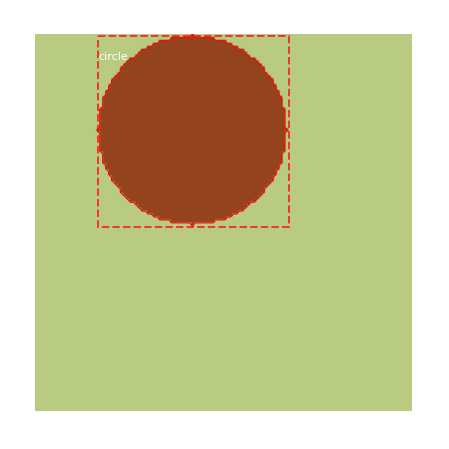

In [16]:
# Test on a random image
image_id = random.choice(dataset_val.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, inference_config, 
                           image_id, use_mini_mask=False)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_train.class_names, figsize=(8, 8))

Processing 1 images
image                    shape: (128, 128, 3)         min:   43.00000  max:  203.00000  uint8
molded_images            shape: (1, 128, 128, 3)      min:  -80.70000  max:   86.20000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  128.00000  int64
anchors                  shape: (1, 4092, 4)          min:   -0.71267  max:    1.20874  float32


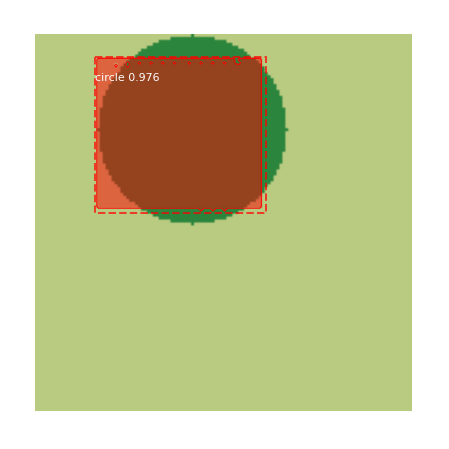

In [17]:
results = model.detect([original_image], verbose=1)

r = results[0]
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'], ax=get_ax())

## Evaluation

In [18]:
# Compute VOC-Style mAP @ IoU=0.5
# Running on 10 images. Increase for better accuracy.
image_ids = np.random.choice(dataset_val.image_ids, 10)
APs = []
for image_id in image_ids:
    # Load image and ground truth data
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, inference_config,
                               image_id, use_mini_mask=False)
    molded_images = np.expand_dims(modellib.mold_image(image, inference_config), 0)
    # Run object detection
    results = model.detect([image], verbose=0)
    r = results[0]
    # Compute AP
    AP, precisions, recalls, overlaps =\
        utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                         r["rois"], r["class_ids"], r["scores"], r['masks'])
    APs.append(AP)
    
print("mAP: ", np.mean(APs))

/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/melvingelbard/opt/anaconda3/envs/mask-rcnn/lib/

mAP:  0.7750000022351742
